## Setup

In [1]:
import datetime
import numpy as np
import pandas as pd
import plotly.express as px

In [2]:
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'noise_dist',
    'scale': 3
  }
}

def show_figure(fig, x_title, y_title):
    fig.update_layout(
        xaxis_title=x_title,
        yaxis_title=y_title,
        width=500,
        height=300,
        font_family="Rockwell",
        font_size=15,
        font_color="black",
        autosize=False,
        margin=dict(l=1, r=1, b=0, t=1, pad=0),
        template="plotly_white",
    )
    fig.update_xaxes(
        showline=True,
        linewidth=1,
        linecolor="black",
        mirror=True,
        ticks="outside",
        ticklabelmode="period",
        minor=dict(ticks="inside", showgrid=True),
    )
    fig.update_yaxes(
        showline=True,
        showgrid=True,
        linewidth=1,
        linecolor="black",
        mirror=True,
        ticks="outside",
        showticklabels=True,
    )
    fig.show(renderer="svg", config=config)

In [3]:
intermittent_failures = pd.read_csv("../../data/labeled_intermittent_failures.csv")
intermittent_failures["created_at"] = pd.to_datetime(intermittent_failures["created_at"], format="mixed", utc=True)

In [6]:
categories = pd.read_csv("../results/categories.csv")
categories.head(5)

,category,group,count,%,count_affected_projects,machine_cost,diagnosis_cost,cost,diagnosis_cost_proportion
0,container_already_exists,container_issues,2,0.04,1,0.90,0.54,1.44,37.50
1,container_not_found,container_issues,31,0.69,7,17.88,19686.51,19704.39,99.91
2,docker_daemon_connection_failure,container_issues,325,7.20,13,21.09,146619.61,146640.70,99.99
3,image_build_permission_denied,container_issues,8,0.18,1,0.75,700.84,701.59,99.89
4,image_build_read_error,container_issues,17,0.38,5,27.67,153653.07,153680.74,99.98


In [7]:
reference_date = datetime.date(2024, 7, 11) # date of collected data

We calculate the recency of each category in number of days

In [8]:
def recency(creation_dates):
    n = 3
    dates = [x.to_pydatetime().date() for x in creation_dates]
    dates.sort()
    last_n_dates = dates[-n:]
    recencies = [(reference_date - d).days for d in last_n_dates]
    return round(np.mean(recencies))


last_occurences = (
    intermittent_failures.groupby("category")
    .agg({"created_at": recency})
    .reset_index()
)
last_occurences.columns = ["category", "recency"]
last_occurences.head()

,category,recency
0,api_gateway_deployment_error,29
1,apt_timezone_issue,964
2,broker_connection_failure,464
3,buggy_dependency,364
4,certificate_verification_failure,89


Then we add it to the categories dataset

In [9]:
categories = categories.drop(columns=["recency"], errors="ignore")
categories = categories.set_index("category").join(last_occurences[["category", "recency"]].set_index("category"))
categories = categories.reset_index()
categories.head()

,category,group,count,%,count_affected_projects,machine_cost,diagnosis_cost,cost,diagnosis_cost_proportion,recency
0,container_already_exists,container_issues,2,0.04,1,0.90,0.54,1.44,37.50,951
1,container_not_found,container_issues,31,0.69,7,17.88,19686.51,19704.39,99.91,70
2,docker_daemon_connection_failure,container_issues,325,7.20,13,21.09,146619.61,146640.70,99.99,915
3,image_build_permission_denied,container_issues,8,0.18,1,0.75,700.84,701.59,99.89,1415
4,image_build_read_error,container_issues,17,0.38,5,27.67,153653.07,153680.74,99.98,223


In [10]:
rfm = categories[["category", "recency", "count", "cost"]]
rfm.columns = ["Category", "Recency", "Frequency", "Monetary"]
print(rfm.shape)
rfm

(46, 4)


,Category,Recency,Frequency,Monetary
0,container_already_exists,951,2,1.44
1,container_not_found,70,31,19704.39
2,docker_daemon_connection_failure,915,325,146640.70
3,image_build_permission_denied,1415,8,701.59
4,image_build_read_error,223,17,153680.74
5,image_push_write_error,983,1,0.12
6,image_security_scan_failure,182,8,65.41
7,db_table_undefined,304,16,11767.83
8,buggy_dependency,364,13,7781.37
9,dependencies_conflict_error,195,129,47211.21


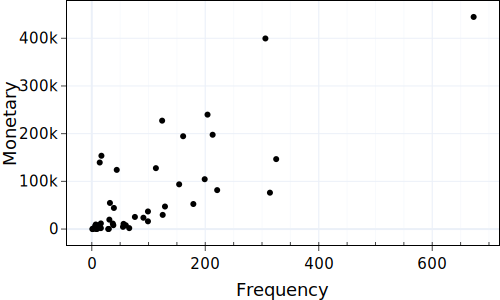

In [11]:
x = "Frequency"
y = "Monetary"
fig = px.scatter(rfm, x=x, y=y, color_discrete_sequence=["black"])
show_figure(fig, x_title=x, y_title=y)

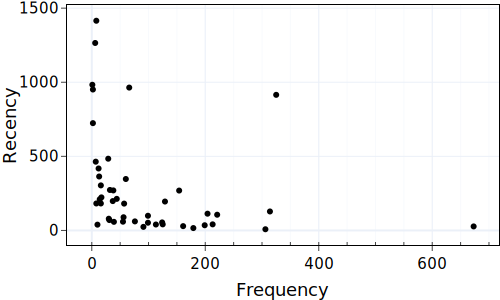

In [12]:
x = "Frequency"
y = "Recency"
fig = px.scatter(rfm, x=x, y=y, color_discrete_sequence=["black"])
show_figure(fig, x_title=x, y_title=y)

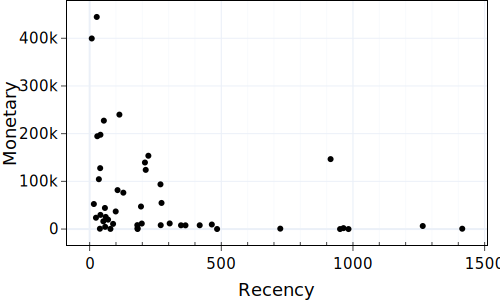

In [13]:
y = "Monetary"
x = "Recency"
fig = px.scatter(rfm, x=x, y=y, color_discrete_sequence=["black"])
show_figure(fig, x_title=x, y_title=y)

In [14]:
df_corr = rfm.drop(columns=["Category"]).corr().round(1)
df_corr

,Recency,Frequency,Monetary
Recency,1.0,-0.3,-0.3
Frequency,-0.3,1.0,0.8
Monetary,-0.3,0.8,1.0


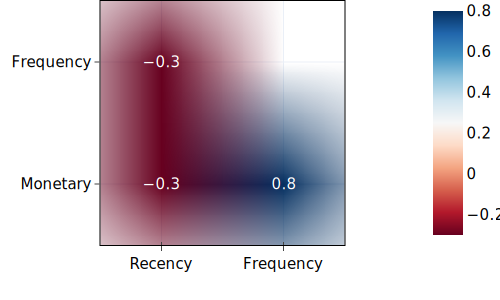

In [15]:
mask = np.zeros_like(df_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Viz
df_corr_viz = df_corr.mask(mask).dropna(how="all").dropna(axis="columns", how="all")
fig = px.imshow(df_corr_viz, text_auto=True, color_continuous_scale=px.colors.diverging.RdBu)
show_figure(fig, x_title="", y_title="")